In [9]:
%matplotlib inline

import numpy as np
import mplcyberpunk
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons

plt.style.use("cyberpunk")

rcParams["font.sans-serif"] = "Roboto"
rcParams["xtick.labelsize"] = 14.
rcParams["ytick.labelsize"] = 14.
rcParams["axes.labelsize"] = 14.
rcParams["legend.fontsize"] = 14
rcParams["axes.titlesize"] = 16.

np.random.seed(42)

_ = torch.manual_seed(42)

# Introduction to PyTorch

In this notebook, we're going to be taking the core ideas from the first notebook, and abstracting all of the computation away using the relatively high-level interface by PyTorch. 

I highly recommend using the PyTorch documentation as a reference, in particular [the page on the `torch.nn` module](https://pytorch.org/docs/stable/nn.html) is where I frequently go back to, as it provides instructions (and equations) on relevant implementations in PyTorch. When in doubt, you can also go one layer deeper into the problem, and start looking into the source code.

## A Guide to the PyTorch Interface

Before we dive into any coding, we should assess how PyTorch as an API is laid out, so you will know where to look for things as you need to. There's also a level of underlying design choices to consider, so that when it comes to routine model building we can take advantage of PyTorch _and_ Python as languages as much as possible. As eluded to in the first notebook, PyTorch is very much an object-oriented and [Pythonic](https://www.python.org/dev/peps/pep-0020/) library, and so there's a strong emphasis on not needing to repeat code by taking advantage of things like inheritance. For the most part, building models in PyTorch is essentially building classes in Python—all of the standard neural network layers are built off the same class, and so will your own models/layers. This substantially reduces the need for a lot of different boiler plate codes, for example when you come to implement training loops.

For most purposes, the `torch.nn` module provides access to high-level, object-oriented implementations of standard neural network building blocks, including your standard fully-connected layer (`nn.Linear`), convolution layers (e.g. `nn.Conv1d`), and recurrent layers (e.g. `nn.LSTMCell`). All of these objects inherit from the `nn.Module` base class, and abstracts away a lot of concepts like nesting multiple layers, saving and loading models, moving your code onto GPUs, and hopping between training and evaluation phases. The `torch.nn` module also provides access to other neural network tools, such as standard activation functions and losses (see notebook 2)—these also inherit from `nn.Module`. 

While `torch.nn` modules give you access to objects that represent the building blocks, when it comes to computation they actually just call routines in their functional `torch.nn.functional` interface; for example, `nn.ReLU()` creates an object that, at runtime, calls `torch.nn.functional.relu()` on your inputs. In principle, you could build entire models using only the functional interface, but because you're giving up the benefits of class inheritance, you will have to write a lot of boiler plate code. An intermediate solution is to write a mixture of `torch.nn` and `torch.nn.functional` calls, but if you want the code to be simple and unified you should keep this to a minimum and use the recommended object-oriented interface. To go down yet another layer, `torch.nn.functional` ends up using low-level C/C++/CUDA routines, including those from Caffe2. The other submodule of `torch` you will frequently access is `torch.optim`, which provides access to various optimization algorithms. Each implemented optimizer inherits from `torch.optim.BaseOptimizer`, which has a very similar implementation to `torch.nn.Module`.

Finally, at the top level of `torch` are standard math functions and random number generation. So for the most part, this is a drop and replace of NumPy routines, like `torch.exp` and `torch.rand`. One key difference between the two interfaces is the keyword argument `axis` in NumPy is actually `dim` in PyTorch. So when performing operations on nominally the type of array, you will have to swap the kwargs.

---

## `torch.Tensor` — the Heart of PyTorch

The `torch.Tensor` is at the core of everything to do with PyTorch.

In [2]:
X = torch.Tensor([0.])

Tensors more or less behave like `numpy.ndarray`, doing all the fancy broadcasting and vectorization stuff. There's two big differences with `torch.Tensor`, however, that make it the true centerpiece of PyTorch:

1. You can move it onto your GPU

In [3]:
if torch.cuda.is_available():
    X.to("cuda")

which it will then subsequently do all its computation on your GPU. This is an easy way to do extremely scalable calculations with minimal change in the way that you code (if you can't write CUDA, for example). The other big difference is:

2. Automatic differentiation

This is definitely more of a general PyTorch thing, but the support for autograd in PyTorch is amazing. The idea is you can perform any combination of computations you want, and you can simply backpropagate through all your calculations to compute the gradient with respect to your tensor. For example:

In [18]:
# Create a PyTorch Variable from a tensor, and ask it to track gradients
X = torch.autograd.Variable(torch.Tensor([10.]), requires_grad=True)

# Do some computation
Y = 20. + X
# Do some probabilistic computation
Y *= torch.rand(1)
Y = torch.sin(Y)

In [19]:
# if you inspect X, it shows that you've specified gradients
print(f"Tensor X: {X}")
print(f"Tensor Y: {Y}")

Tensor X: tensor([10.], requires_grad=True)
Tensor Y: tensor([-0.4837], grad_fn=<SinBackward>)


In [20]:
# Compute gradients
Y.backward()

In [21]:
# Calculate the dY/dX
X.grad

tensor([-0.8396])

The important thing about this easy access to auto differentiation is for all of our neural network building: because we work with tensors, all of which support this feature, we can perform backpropagation for training without even needing to think about the problem as it does a bunch of chain rule computations in the background. In general, this is also a nifty feature because it means if you ever need to compute derivatives of complicated functions, you know you can do it numerically with PyTorch quite easily.

Instead of calling `Y.backward()`, you can also access the automatic differentiation interface with the `torch.autograd` module. This gives you some freedom to perform the computation, say if you wanted to take partial derivatives with respect to specific variables.

In [26]:
A = torch.autograd.Variable(torch.Tensor([3.]), requires_grad=True)
B = torch.autograd.Variable(torch.Tensor([23.]), requires_grad=True)

C = (A * B) / (A + B)
C = torch.sigmoid(C)

print(f"Tensor C: {C}")

Tensor C: tensor([0.9342], grad_fn=<SigmoidBackward>)


In [27]:
# Take derivative of C with respect to B
torch.autograd.backward([C], [B])

In [28]:
# dC/dB
B.grad

tensor([0.0188])

If you want to do the same computation for `A`, you'll have to ask it to `retain_graphs=True`: by default once autograd is done, the computational graph used for the chain of calculations is freed up.

## Building a PyTorch model

We now have all the ingredients necessary to start doing deep learning with PyTorch. As mentioned previously, everything is built 

In [29]:
data, labels = make_moons(n_samples=1000, noise=0.1)

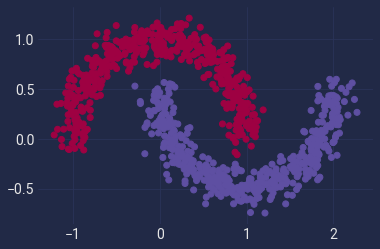

In [30]:
fig, ax = plt.subplots()

ax.scatter(data[:,0], data[:,1], c=labels, cmap="Spectral")